In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
import netCDF4 as nc

#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.35_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.2_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.15_N=100000.nc'

dataset = 'viscek/dt=0.010_rho=1.000_v=0.500_a=4.000_eta=0.100_N=100000.nc'
# (don't interpolate)

ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["time"])
n_particles = len(ds.dimensions["director"])
deltat = 1
# deltat = 0.01
v = 0.5
positions = np.array(ds.variables["position"]).T.astype('float64')
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"]).astype('float64')
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): Nv(100000), dof(200000), boxdim(4), unit(1), time(1000), position(200000), director(100000)
    variables(dimensions): float32 time(time), float32 position(time, position), float32 director(time, director)
    groups: 
(1000, 100000)
(100000, 2, 1000)
(100000, 2, 1000)
[ 316.22775196  316.22775196 1000.        ]


0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


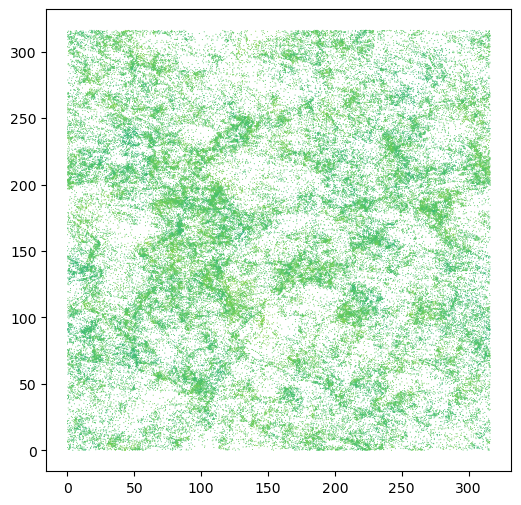

In [18]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viscek/eta0.1_t0.01.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [16]:
#%%prun # profiling

from interp import *
from utils import roll, unroll

### computational effort can be cut down by only interpolating at domain locations, 
### but on the other hand the current way allows interpolation to be one and done
interp_factor = 10 #10x interpolation of data on intermediate times
old_pos = positions
old_vs = vs
positions, psplines = interp(unroll(positions, world_size), interp_factor, k=3)
print(positions.shape)
positions = roll(positions, world_size)
print(positions.shape)
vs, vsplines = interp(vs, interp_factor, k=3)
# overwrite vs using derivative of psplines (optional, not sure this is at all a good idea)
eval_pts = np.linspace(0, 1, num=positions.shape[-1])
derivative_vsplines = [spline.derivative() for spline in psplines]
derivative_vs_list = [vspline(eval_pts) for vspline in derivative_vsplines]
vs = np.transpose(np.dstack(derivative_vs_list))/(world_size[-1]-1) # normalization of e.g. [0, 49] to [0, 1]

deltat /= interp_factor
world_size[-1] = (world_size[-1]-1)*interp_factor+1

interesting = None # particle that wraps around
for i in range(positions.shape[0]):
    if np.max(np.abs(positions[i, :, 1:]-positions[i, :, :-1]))>100:
        interesting = i
plot_interp(old_pos[interesting, :, :], positions[interesting, :, :])
plot_interp(old_vs[interesting, :, :21], vs[interesting, :, :201])
print(positions[0, 0, 0:100:10], old_pos[0, 0, :10])
save('Q_XY_0.35_interp.npy', positions, vs, psplines, vsplines)

KeyboardInterrupt: 

In [4]:
%%prun # profiling

#positions, vs = load('Q_XY_0.35_interp.npy', 2)

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
kernel_sigma = 2
cg_res = 1
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 80
dom_time = 50 #previously 20 (without interpolation)
srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*8) #ndomains = 30
srd.make_weights(m=8, qmax=1)
corr_L = 5
srd.set_LT_scale(L=corr_L, T=corr_L/v) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

#save('Q_XY_0.35.npy', srd.dxs, srd.libs)
save('Q_XY_t0.01_eta0.1.npy', srd.dxs, srd.libs)

         15925408 function calls (15128473 primitive calls) in 4497.721 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      150 4028.603   26.857 4028.606   26.857 coarse_grain_utils.py:93(coarse_grain_time_slices)
    39600  146.454    0.004  146.564    0.004 diff.py:478(_apply_to_array)
      888   93.983    0.106 4424.320    4.982 process_library_terms.py:370(make_tw_arr)
    39960   63.570    0.002   66.804    0.002 function_base.py:4129(trapz)
822914/396359   50.335    0.000  130.547    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    27480   21.008    0.001   61.535    0.002 process_library_terms.py:74(get_weight_array)
    27360   20.775    0.001 4328.140    0.158 process_library_terms.py:184(eval_term)
      150   15.993    0.107 4050.775   27.005 process_library_terms.py:223(eval_cgp)
    13200    8.972    0.001  171.719    0.013 diff.py:277(diff)
   246231    5.319    0.000    5.

In [5]:
#_, libs = load('Q_XY_0.35.npy', 2)
_, libs = load('Q_XY_t0.01_eta0.1.npy', 2)
libs = libs.item()

In [6]:
from identify_models import *
opts = dict()
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
opts['method'] = "stepwise"
#opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2

[0.02 s]
Identified model: -0.25000000000000006 * rho + 1.0 * rho[v_j * v_j] = 0 (order 3, residual 2.89e-16)
[0.03 s]
Identified model: 1.0 * dj rho[v_j] + 0.9996960427418706 * dt rho = 0 (order 3, residual 2.00e-04)
[0.03 s]
Identified model: -0.24460398357380583 * rho * rho + 1.0 * rho[v_j] * rho[v_j] = 0 (order 4, residual 2.49e-03)
[0.09 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + -0.24999999999999994 * rho[v_i] = 0 (order 4, residual 2.98e-16)
[0.08 s]
Identified model: -0.24483160606292642 * rho * dt rho + 1.0 * rho[v_j] * dt rho[v_j] = 0 (order 5, residual 2.10e-03)
[0.14 s]
Identified model: 1.0 * dj dk rho[v_j * v_k] + -0.9872783428115021 * dt^2 rho = 0 (order 5, residual 8.88e-03)
[0.64 s]
Identified model: -0.24999999999999992 * rho * rho[v_i] + 1.0 * rho[v_i] * rho[v_j * v_j] = 0 (order 5, residual 8.00e-16)
[1.14 s]
Identified model: -0.2446651324612453 * rho * rho[v_i] + 1.0 * rho[v_j] * rho[v_i * v_j] = 0 (order 5, residual 3.41e-03)
[1.59 s]
Identified model: 0.9

In [7]:
opts1['inhomog'] = True
opts1['method'] = 'stepwise'
#opts1['subinds'] = None # if interleave_identify has been run, the subinds need to be cleared
opts1['verbose'] = True
opts1['inhomog_col'] = 13 # dt rho[v_i]
Xi, lambd, best_term, lambda1 = sparse_reg(libs[1].Q, **opts1)
zipped = [(libs[1].terms[i], c) for i, c in enumerate(Xi) if c != 0]
print(Equation([e[0] for e in zipped], [e[1] for e in zipped]), "; residual:", lambd)

Thetanm: 31831.219629863535
lambda: 0.03590788488747486
nrm[0]: 0.2809800737341111
nrm[1]: 0.12205060336949185
nrm[2]: 0.11892971459605087
nrm[3]: 0.08082219328965796
nrm[4]: 0.07656076863785397
nrm[5]: 0.06873509030074071
nrm[6]: 0.4755853319428404
nrm[7]: 0.3420116325897396
nrm[8]: 0.6747348150154373
nrm[9]: 0.1965118775453964
nrm[10]: 1.8668247247526983
nrm[11]: 0.3553133404795376
nrm[12]: 0.2740477267557067
nrm[13]: 0.15040122047156726
nrm[14]: 0.2389649277818965
nrm[15]: 0.2084332509932161
nrm[16]: 3.65181362844549
nrm[17]: 2.473820126258444
nrm[18]: 0.4445814482291584
nrm[19]: 1.4619140748129307
nrm[20]: 0.5832905825572566
nrm[21]: 0.5059158623546055
nrm[22]: 0.6111812493584167
nrm[23]: 0.6032229757839045
nrm[24]: 0.952653813643725
y: [1.] ii: 24
i 0 lambda 0.03590788488747486
y: [1.] ii: 17
i 1 lambda 0.03591210982577383
y: [1.001] ii: 3
i 2 lambda 0.03592038735797632
y: [1.002] ii: 16
i 3 lambda 0.03594588082775061
y: [1.005] ii: 18
i 4 lambda 0.03600466921304465
y: [1.004] ii:

In [10]:
Xi = [ 0.,     0.,     0.,     0.,    -1.835,  0.,    -0.088,  0.,    -0.034,  0.21,
   0.,     0.,     0.,    -1.,     0.,     0.,     0.,     0.,     0.,     0.,
   0.,     0.,     0.129,  0.,     0.   ]
Xi2 = [ 0.,     0.,     0.,     0.,    -1.52,   0.,    -0.114,  0.,    -0.041,  0.,
   0.,     0.,     0.,    -1.,     0.,     0.,     0.,     0.,     0.,     0.,
   0.,     0.,     0.12,   0.,     0.   ]
lambd = 0.051
lambd2 = 0.054
zipped = [(libs[1].terms[i], c) for i, c in enumerate(Xi) if c != 0]
print(Equation([e[0] for e in zipped], [e[1] for e in zipped]), "; residual:", lambd)
zipped = [(libs[1].terms[i], c) for i, c in enumerate(Xi2) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])
print(eqn, "; residual:", lambd2)


-1.0 * dt rho[v_i] + -1.835 * dt^2 di rho + -0.088 * rho * di rho + -0.034 * rho * dt di rho + 0.21 * rho * dt^2 di rho + 0.129 * rho * dt^2 rho[v_i] = 0 ; residual: 0.051
-1.0 * dt rho[v_i] + -1.52 * dt^2 di rho + -0.114 * rho * di rho + -0.041 * rho * dt di rho + 0.12 * rho * dt^2 rho[v_i] = 0 ; residual: 0.054


In [ ]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [9]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size, term.complexity)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size, term.complexity)

0 1 1 0
1 rho 1.000000856355482 1
2 dj^2 rho 0.03626101773720872 3
3 dj^2 dk^2 rho 0.0014504407094883486 5
4 dt rho 0.0906525443430218 2
5 dt dj^2 rho 0.0036261017737208717 4
6 dt dj^2 dk^2 rho 0.00014504407094883485 6
7 dt^2 rho 0.00906525443430218 3
8 dt^2 dj^2 rho 0.00036261017737208715 5
9 dt^3 rho 0.0009065254434302179 4
10 dt^3 dj^2 rho 3.626101773720872e-05 6
11 dt^4 rho 9.065254434302179e-05 5
12 dt^5 rho 9.06525443430218e-06 6
13 rho * rho 1.0000017127116976 2
14 rho * dj^2 rho 0.03626104878953004 4
15 rho * dj^2 dk^2 rho 0.0014504419515812017 6
16 rho * dt rho 0.09065262197382509 3
17 rho * dt dj^2 rho 0.0036261048789530043 5
18 rho * dt^2 rho 0.00906526219738251 4
19 rho * dt^2 dj^2 rho 0.0003626104878953004 6
20 rho * dt^3 rho 0.000906526219738251 5
21 rho * dt^4 rho 9.06526219738251e-05 6
22 rho * rho * rho 1.0000025690686463 3
23 rho * rho * dj^2 rho 0.03626107984187796 5
24 rho * rho * dt rho 0.0906526996046949 4
25 rho * rho * dt dj^2 rho 0.003626107984187796 6
26 rho *

In [ ]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho', 'dj rho[v_j]', 'dt^2 rho', 'dj^2 rho']

#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['1']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

In [ ]:
print(libs[0].Q[:10, 4], libs[0].Q[:10, 35])

-1.0 * dt rho[v_i] + -1.52 * dt^2 di rho + -0.114 * rho * di rho + -0.041 * rho * dt di rho + 0.12 * rho * dt^2 rho[v_i] = 0
frame=0
frame=0
frame=0
frame=10
frame=20
frame=30
frame=40


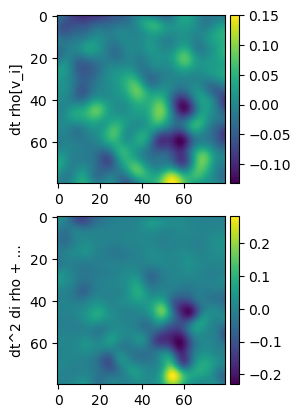

In [14]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test.mp3'

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

def make_all_but_first(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs[1:])[..., 0]

domain = srd.domains[0]
kc = 0 # can select x, y components

print(eqn)

term1 = srd.libs[1].terms[find_term(libs[1].terms, 'dt rho[v_i]')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)[..., 0]
fig, (ax1, ax2) = plt.subplots(2, 1)
im1 = ax1.imshow(tw_arr[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

tw_arr2 = make_all_but_first(eqn, domain, kc) # or 
im2 = ax2.imshow(tw_arr2[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel("dt^2 di rho + ...")

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    im1.set_array(tw_arr[:, :, i])
    im2.set_array(tw_arr2[:, :, i])
    vmax1 = np.max(tw_arr[:, :, i])
    vmin1 = np.min(tw_arr[:, :, i])
    vmax2 = np.max(tw_arr2[:, :, i])
    vmin2 = np.min(tw_arr2[:, :, i])
    im1.set_clim(vmin1, vmax1)
    im2.set_clim(vmin2, vmax2)

    return im1, im2

anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=100, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
#anim.save(vid_file, writer=FFwriter, dpi=100)
HTML(anim.to_html5_video())

#plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tw_arr[0, 0, :])
ax.plot(tw_arr[1, 0, :])
ax.plot(tw_arr[2, 0, :])

In [23]:
constraint_terms = ['rho', 'rho[v_j * v_j]']
col_numbers = [find_term(libs[0].terms, name) for name in constraint_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 1] -0.25000000000000006 * rho. (Char. size: 1.0000000889047715)
[Term 22] 1.0 * rho[v_j * v_j]. (Char. size: 0.12500001111309633)
Model residual: 2.420039324384364e-16


In [24]:
wave_terms = ['dt^2 rho', 'dj^2 rho']
col_numbers = [find_term(libs[0].terms, name) for name in wave_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 2] -0.14914080110007913 * dj^2 rho. (Char. size: 0.025842687247454435)
[Term 6] 1.0 * dt^2 rho. (Char. size: 0.006460671811863609)
Model residual: 0.6126455299935258


In [25]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 13] 0.9946772839734203 * dt rho[v_i]. (Char. size: 0.014858654141425598)
[Term 24] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.006834571057737082)
Model residual: 0.21962171446694487


In [33]:
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']
euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho', 'dj^2 rho[v_i]']
#euler_terms = ['dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in euler_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] 0.004302452169490613 * di rho. (Char. size: 0.12921343623727216)
[Term 12] -0.01214458919359336 * dj^2 rho[v_i]. (Char. size: 0.005943461656570239)
[Term 13] 1.0 * dt rho[v_i]. (Char. size: 0.014858654141425598)
[Term 24] 0.985503322889241 * dj rho[v_i * v_j]. (Char. size: 0.006834571057737082)
Model residual: 0.21648228755467183


In [15]:
toner_tu_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho[v_i] * dj rho[v_j]', 'rho[v_i]',
                'di rho', 'dj^2 rho[v_i]', 'di dj rho[v_j]']#, 'dj dk rho[v_i * v_j * v_k]', 
                #'rho * di rho', 'rho * rho * di rho']
# third term is a bit sketchy
col_numbers = [find_term(libs[1].terms, name) for name in toner_tu_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] 0.005934510713038656 * di rho. (Char. size: 0.12921343623727216)
[Term 10] -4.691692164194123e-05 * rho[v_i]. (Char. size: 0.35355342202585704)
[Term 11] -0.1843931232999184 * di dj rho[v_j]. (Char. size: 0.005943461656570239)
[Term 12] 0.07524778237145681 * dj^2 rho[v_i]. (Char. size: 0.005943461656570239)
[Term 13] 1.0 * dt rho[v_i]. (Char. size: 0.014858654141425598)
[Term 24] 0.8798534301810929 * dj rho[v_i * v_j]. (Char. size: 0.006834571057737082)
[Term 27] 0.06066461023801594 * rho[v_i] * dj rho[v_j]. (Char. size: 0.010506656036799386)
Model residual: 0.2045986589683251


In [ ]:
0.03 (0.99998), 0.018, 0.12, 0.08